In [34]:
import pandas as pd
import numpy as np
df = pd.read_csv('../dataset/upbit_ohlcv_1700.csv')

In [2]:
df.shape

(1700, 7)

In [3]:
df.head()

,index,open,high,low,close,volume,value
0,2017-09-29 09:00:00+09:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
1,2017-09-30 09:00:00+09:00,4657000.0,4896000.0,4651000.0,4895000.0,19.998483,9.561476e+07
2,2017-10-01 09:00:00+09:00,4889000.0,4978000.0,4682000.0,4962000.0,27.323332,1.331325e+08
3,2017-10-02 09:00:00+09:00,4962000.0,5095000.0,4956000.0,5025000.0,31.728004,1.599315e+08
4,2017-10-03 09:00:00+09:00,5021000.0,5079000.0,4811000.0,4964000.0,11.899307,5.890130e+07


In [19]:
df['index'] = pd.to_datetime(df['index'], format="%Y-%m-%d %H:%M:%S")
df.set_index('index', inplace=True)
df.head()

,open,high,low,close,volume,value
index,,,,,,
2017-09-29 09:00:00+09:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
2017-09-30 09:00:00+09:00,4657000.0,4896000.0,4651000.0,4895000.0,19.998483,9.561476e+07
2017-10-01 09:00:00+09:00,4889000.0,4978000.0,4682000.0,4962000.0,27.323332,1.331325e+08
2017-10-02 09:00:00+09:00,4962000.0,5095000.0,4956000.0,5025000.0,31.728004,1.599315e+08
2017-10-03 09:00:00+09:00,5021000.0,5079000.0,4811000.0,4964000.0,11.899307,5.890130e+07


<AxesSubplot:>

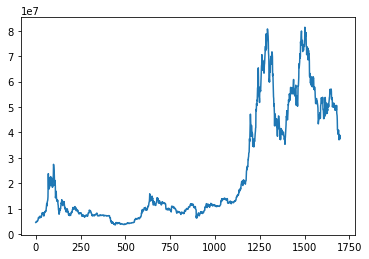

In [4]:
df['open'].plot()

In [22]:
ts_selected = df['open']

In [23]:
input_window = 90
output_window = 28
train_rate = 0.7

In [24]:
train_size = int((len(ts_selected)-output_window) * train_rate)
valid_size = (len(ts_selected)-28)- train_size

print(train_size)
print(valid_size)

1170
502


In [27]:
train_data = ts_selected.iloc[:train_size]
valid_data = ts_selected.iloc[train_size:train_size+valid_size]

In [35]:
train_data = np.array(train_data).reshape(-1,1)
valid_data = np.array(valid_data).reshape(-1,1)

In [36]:
train_data.shape


(1170, 1)

In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [39]:
scaler.fit(train_data)

MinMaxScaler()

In [40]:
train_data_std = scaler.transform(train_data)
valid_data_std = scaler.transform(valid_data)

In [42]:
train_data_std.shape

(1170, 1)

In [43]:
pd.DataFrame(train_data_std)

,0
0,0.040535
1,0.043515
2,0.053250
3,0.056313
4,0.058789
...,...
1165,0.728295
1166,0.722336
1167,0.688389
1168,0.697914


In [45]:
from torch.utils.data import Dataset
import torch


class WindowDataset(Dataset):
    '''
    Build a custom dataset 
    
    --Return--
    
    x: inputs
    y: targets 
    z: features
    ----------
    
    '''
    
    def __init__(self, data, input_window, output_window, stride=1):
        # total data length 
        L = data.shape[0]
        
        # total number of samples with stride
        num_samples = (L - input_window - output_window) // stride + 1
        
        # input, output 
        X = []
        Y = []
        Z = []
        
        for i in range(num_samples):
            start_x = stride*i
            end_x = start_x + input_window 
            X.append(data.iloc[start_x: end_x, :].values)
            
            start_y = stride*i + input_window
            end_y = start_y + output_window 
            Y.append(data.iloc[start_y:end_y, 0].values)
            Z.append(data.iloc[start_y:end_y, 1:].values)
            
        self.x = X
        self.y = Y
        self.z = Z
        
        self.len = len(X)
            
    def __len__(self):
        return self.len 
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x[idx])
        y = torch.FloatTensor(self.y[idx])
        y = y.unsqueeze(-1)
        z = torch.FloatTensor(self.z[idx])
        
        return x, y, z

In [46]:
from torch.utils.data import DataLoader
target_feature = 'open'
batch_size=64

df = pd.read_csv('../dataset/upbit_ohlcv_1700.csv')

#-- make datetime index
df['index'] = pd.to_datetime(df['index'], format="%Y-%m-%d %H:%M:%S")
df.set_index('index', inplace=True)

#-- train validation split 
ts_selected = df[target_feature]
train_size = int((len(ts_selected)-output_window) * train_rate)
valid_size = (len(ts_selected)-output_window)- train_size
train_data = np.array(ts_selected.iloc[:train_size]).reshape(-1,1)
valid_data = np.array(ts_selected.iloc[train_size:train_size+valid_size]).reshape(-1,1)

#-- normalize data
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data_std = scaler.transform(train_data)
valid_data_std = scaler.transform(valid_data)   
# joblib.dump(scaler, os.path.join(log_dir, 'scaler.pkl'))

#-- get dataloader
train = pd.DataFrame(train_data_std)
valid = pd.DataFrame(valid_data_std)

train_dataset = WindowDataset(train, input_window, output_window)
train_dataloader = DataLoader(train_dataset, batch_size)  

valid_dataset = WindowDataset(valid, input_window, output_window)
valid_dataloader = DataLoader(valid_dataset, batch_size)     



In [48]:
x,y,z = next(iter(train_dataloader))

In [49]:
x.shape

torch.Size([64, 90, 1])

In [50]:
y.shape

torch.Size([64, 28, 1])

In [51]:
z.shape

torch.Size([64, 28, 0])

In [55]:
target_len = 28
input_window = 90
target_feature = 'open'

df_ = pd.read_csv('../dataset/upbit_ohlcv_1700.csv')

real = df_[target_feature].to_numpy()
pred = np.array(df_.iloc[-(input_window + target_len):-target_len, :][target_feature])
pred = pred.reshape(-1,1)
pred_std = scaler.transform(pred)

In [56]:
pred_std.shape

(90, 1)

In [58]:
torch.tensor(pred_std).shape

torch.Size([90, 1])

# Inference

In [101]:
import pickle 
import joblib 
import matplotlib.pyplot as plt
history = joblib.load('../logs/history.pkl')

In [102]:
train_loss = history['train'][0]['train_loss']
len(train_loss)

3000

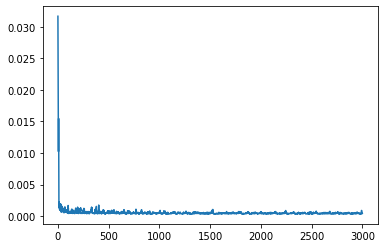

In [103]:
plt.plot(range(len(train_loss)), train_loss)

In [104]:
valid_loss = history['valid'][0]['valid_loss']
len(valid_loss)

3000

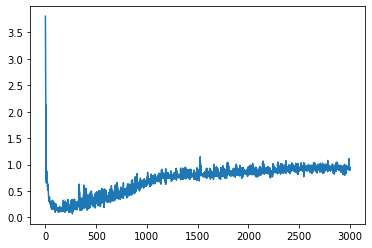

In [105]:
plt.plot(range(len(valid_loss)), valid_loss)

In [106]:
#-- Seq2Seq    
class seq2seq(nn.Module):
    def __init__(self, input_size, hidden_size, target_len):

IndentationError: expected an indented block (920135153.py, line 3)

In [107]:
import joblib
import sys
sys.path.append('../')
from model import *


In [108]:
hidden_size = 32
output_window=28
input_window=90

In [109]:
df = pd.read_csv('../dataset/upbit_ohlcv_1700.csv')

scaler = joblib.load('../logs/scaler.pkl')

pred = np.array(df.iloc[-(input_window + target_len):-target_len, :][target_feature])
pred = pred.reshape(-1,1)
pred_std = scaler.transform(pred)

model = seq2seq(1, hidden_size, output_window)
model.load_state_dict(torch.load('../logs/model.pth'))



<All keys matched successfully>

In [110]:
device = 'cuda'
predict = model.predict(torch.tensor(pred_std).float())

predict = scaler.inverse_transform(predict.reshape(-1,1))
real = df[target_feature].to_numpy()

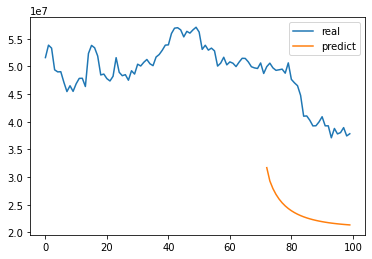

In [112]:
plt.plot(range(100), real[-100:], label='real')
plt.plot(range(100-target_len, 100), predict, label='predict')

plt.legend()
plt.show()

In [113]:
predict

array([[31699700.],
       [29295886.],
       [27922362.],
       [26869678.],
       [26030520.],
       [25349012.],
       [24787026.],
       [24317484.],
       [23920712.],
       [23582140.],
       [23290792.],
       [23038240.],
       [22817936.],
       [22624708.],
       [22454414.],
       [22303706.],
       [22169844.],
       [22050558.],
       [21943964.],
       [21848464.],
       [21762718.],
       [21685578.],
       [21616052.],
       [21553292.],
       [21496558.],
       [21445204.],
       [21398670.],
       [21356456.]], dtype=float32)

In [114]:
real[-28:]

array([49954000., 50580000., 49731000., 49283000., 49383000., 49501000.,
       48772000., 50631000., 47650000., 47030000., 46507000., 44763000.,
       41000000., 41044000., 40263000., 39246000., 39270000., 39967000.,
       40902000., 39260000., 39260000., 37100000., 38781000., 37798000.,
       38037000., 38933000., 37436000., 37827000.])

In [115]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [116]:
MAPEval(predict, real[-28:].reshape(-1,1))

45.25451699987933